### Plots
Plots performance for best model, per category and multiclass vs binary, and balanced accuracy for each category, for comparison with literature.

In [68]:
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt

In [69]:
sns.set_style('whitegrid')

Load and concatenate all the performance files

In [71]:
audio = pd.read_json('../logs/aggregates/audio_performance.jsonl', lines=True)
dummy = pd.read_json('../logs/aggregates/dummy_models.jsonl', lines=True)

In [72]:
all_performances = pd.concat([audio, dummy], ignore_index=True)

Also map model names to something simpler

In [73]:
mapping = json.load(open('../logs/model_name_mapping.json'))
all_performances['model_id'] = all_performances['model_name'].map(mapping)

#### Make result table

Performances:
- Overall F1 macro;
- Multiclass F1, for each diagnosis;
- Binary F1, for each diagnosis;

In [74]:
all_performances[(all_performances['binary']==1) & 
                 (all_performances['score_type']=='f1') & 
                 (all_performances['level']=='id')].target_class.unique()

array(['DEPR', 'ASD', 'SCHZ'], dtype=object)

In [75]:
def make_performance_table(binary=False):
    dfs = []
    cats = ['ASD', 'DEPR', 'SCHZ']
    metrics = ['f1']
    if binary is False:
        cats = ['overall'] + cats
        metrics = metrics + ['f1_macro']
    for cl in cats:
        if binary is False:
            target_class = 'multiclass'
        else:
            target_class = cl
        reduced = all_performances[(all_performances['score_type'].isin(metrics)) & #.str.contains('f1_macro')) &
                                (all_performances['binary']==int(binary)) & 
                                (all_performances['target_class']==target_class) & 
                                (all_performances['class']==cl) & 
                                (all_performances['level']=='id')
                                ][['value', 'model_id', 'class', 'split', 'type']].replace({'validation': 'val'})
        reduced = pd.pivot(reduced, 
                        columns=['class', 'split'], 
                        values='value', 
                        index=['model_id', 'type']).reset_index()
        for c in reduced.columns:
            if reduced[c].dtype == float:
                reduced[c] = reduced[c].round(3)
        reduced = reduced.rename({'overall': 'F1 Macro - Overall',
                                  'ASD': 'F1 - ASD',
                                  'DEPR': 'F1 - DEPR',
                                  'SCHZ': 'F1 - SCHZ',
                                  'type': 'Modality',
                                  'model_id': 'Model',
                                  'train': 'Train',
                                  'val': 'Validation',
                                  'test': 'Test'}, axis=1).reset_index(drop=True)
       
        
        if binary is True:
            reduced = reduced.sort_values(by=(f'F1 - {cl}', 'Test'),
                                          ascending=False)
            reduced.to_latex(buf=open(f'../tables/{cl}_table.tex','w'), 
                             index=False, 
                             index_names=False, 
                             multicolumn_format='c',
                             column_format='rc||ccc')
        else:
            reduced = reduced.iloc[:,[0,1,4,3,2]]
            dfs.append(reduced)

    if binary is False:
        formats = f'rc||ccc||ccc||ccc||ccc'
        for i in range(len(dfs)-1):
            if i==0:
                left = dfs[i]
            else:
                left = perfs
            perfs = left.merge(dfs[i+1], on=['Model','Modality'])
            if binary is False:
                perfs = perfs.sort_values(by=('F1 Macro - Overall', 'Test'), ascending=False)
            
        perfs.to_latex(buf=open(f'../tables/multiclass_table.tex','w'), 
                       index=False, 
                       index_names=False, 
                       multicolumn_format='c',
                       column_format=formats)

In [76]:
make_performance_table(binary=False)
# make_performance_table(binary=True)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_14342/3807540720.py:56: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  perfs = left.merge(dfs[i+1], on=['Model','Modality'])
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_14342/3807540720.py:56: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  perfs = left.merge(dfs[i+1], on=['Model','Modality'])
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_14342/3807540720.py:56: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  perfs = left.merge(dfs[i+1], on=['Model','Modality'])
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_14342/3807540720.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments sig

#### Plot performances

Define some useful functions

In [77]:
def filter_models(perf_df, binary=1, dummy=False, overall=False, metric='f1'):
    ''' Filter performances of interest (F1s) '''
    if metric == 'f1':
        condition_metric = (perf_df['score_type'].isin(['f1_macro', 'f1']))
    elif metric == 'balanced_accuracy':
        condition_metric = (perf_df['score_type']=='balanced_accuracy')
    filt_perf = perf_df[condition_metric & 
                        (perf_df['split']=='test') & 
                        (perf_df['level']=='id') & 
                        (perf_df['binary']==binary)] 
    if metric == 'f1':
        filt_perf = filt_perf[(~filt_perf['class'].isin(['overall', 'TD'])
                                if overall is False
                                else filt_perf['class']=='overall')] 
    else:
        if dummy is True:
            filt_perf = filt_perf[(~filt_perf['class'].isin(['overall', 'TD'])
                                    if overall is False
                                    else filt_perf['class']=='overall')]  
        else:
            filt_perf = filt_perf[filt_perf['class']=='overall']
    filt_perf = filt_perf[(filt_perf['model_id']!='Dummy' 
                           if dummy is False 
                           else filt_perf['model_id']=='Dummy')]
    if metric == 'f1':
        filt_perf = filt_perf[['class', 'value', 'binary', 'model_id', 'is_baseline']]
    else:
        filt_perf = filt_perf[['value', 'binary', 
                               'model_id', 'is_baseline', 'target_class']].rename({'target_class': 'class'},
                                                                                  axis=1)
    return filt_perf

In [78]:
def get_top_f1_macro(perf_df):
    ''' Get models that score best on average F1 in multiclass setting '''
    filt_perf = perf_df[perf_df['score_type'].isin(['f1_macro', 'f1']) & 
                        (perf_df['split']=='test') & 
                        (perf_df['level']=='id') & 
                        (perf_df['binary']==0) & 
                        (~perf_df['class'].isin(['overall', 'TD'])) & 
                        (perf_df['model_id']!='Dummy')][['class', 'value', 'binary', 'model_id', 'is_baseline']]
    filt_perf = filt_perf.groupby(['model_id']).agg({'value': 'mean',
                                                     'binary': 'first',
                                                     'is_baseline': 'first'}).reset_index()
    return filt_perf

In [79]:
def select_top_models(df, overall=False):
    ''' Select top 5 models for each class and transformer vs. baseline '''
    if overall is False:
        grouped = df.groupby(['class', 'is_baseline']).apply(lambda x: x.drop(['class',
                                                                               'is_baseline'], 
                                                                              axis=1).sort_values(by='value', 
                                                                                ascending=False).head(n=5))
        return grouped.reset_index().drop('level_2', axis=1)
    else:
        grouped = df.groupby(['is_baseline']).apply(lambda x: x.drop(['is_baseline'], 
                                                                     axis=1).sort_values(by='value', 
                                                                                         ascending=False).head(n=5))
        grouped['class'] = 'overall'
        return grouped.reset_index().drop('level_1', axis=1)

    

Now extract top performing models and combined the datasets

In [80]:
binary_perf = select_top_models(filter_models(all_performances, binary=1))
multi_perf = select_top_models(filter_models(all_performances, binary=0))
overall_perf = select_top_models(get_top_f1_macro(all_performances), overall=True)

Also extract balanced_accuracy for later use (and concatenate with meta-analysis)

In [81]:
binary_acc = filter_models(all_performances, 
                           binary=1, 
                           metric='balanced_accuracy')
binary_dummy = filter_models(all_performances, 
                           binary=1, dummy=True,
                           metric='balanced_accuracy')
binary_acc = pd.concat([binary_dummy, binary_acc], ignore_index=True)         
asd_data = [{'class': 'ASD', 
             'model_id': f'meta_analysis_{i}',
             'value': v,
             'binary': 1,
             'is_baseline': 2} 
             for i, v in enumerate([0.83, 0.97, 0.79, 
                                    0.63, 0.86, 0.74, 
                                    0.79, 0.7165, 0.82, 
                                    0.8109])]  
sch_data = [{'class': 'SCHZ', 
             'model_id': f'meta_analysis_{i}',
             'value': v,
             'binary': 1,
             'is_baseline': 2} 
             for i, v in enumerate([0.7564, 0.7942, 0.7892, 
                                    0.875, 0.7619, 0.856, 
                                    0.77, 0.91, 0.86])]   
binary_acc = pd.concat([binary_acc, pd.DataFrame(asd_data)])
binary_acc = pd.concat([binary_acc, pd.DataFrame(sch_data)])

In [82]:
combined = pd.concat([binary_perf, multi_perf], ignore_index=True)
combined = pd.concat([combined, overall_perf], ignore_index=True)
combined['binary'] = combined['binary'].map({1: 'binary', 0: 'multiclass'})
combined['model_type'] = combined['is_baseline'].map({1: 'baseline', 0: 'transformer'})
dummies = filter_models(all_performances, binary=0, dummy=True, overall=True)

The next block extracts minimum and maximum for each class and baseline vs. transformer combination (useful to make plot prettier)

In [83]:
lines = {0: {0: [], 1:[]}, 
         1: {0: [], 1:[]}}
for c in ['ASD', 'DEPR', 'SCHZ']:
    for mt in [0, 1]:
        lines[0][mt].append([binary_perf[(binary_perf['class']==c) & (binary_perf['is_baseline']==mt)]['value'].min(),
                             binary_perf[(binary_perf['class']==c) & (binary_perf['is_baseline']==mt)]['value'].max()])
        lines[1][mt].append([multi_perf[(multi_perf['class']==c) & (multi_perf['is_baseline']==mt)]['value'].min(),
                             multi_perf[(multi_perf['class']==c) & (multi_perf['is_baseline']==mt)]['value'].max()])
for mt in [0, 1]:
    lines[1][mt].append([overall_perf[(overall_perf['class']=='overall') & (overall_perf['is_baseline']==mt)]['value'].min(),
                         overall_perf[(overall_perf['class']=='overall') & (overall_perf['is_baseline']==mt)]['value'].max()])

And finally plot all the scores

In [84]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

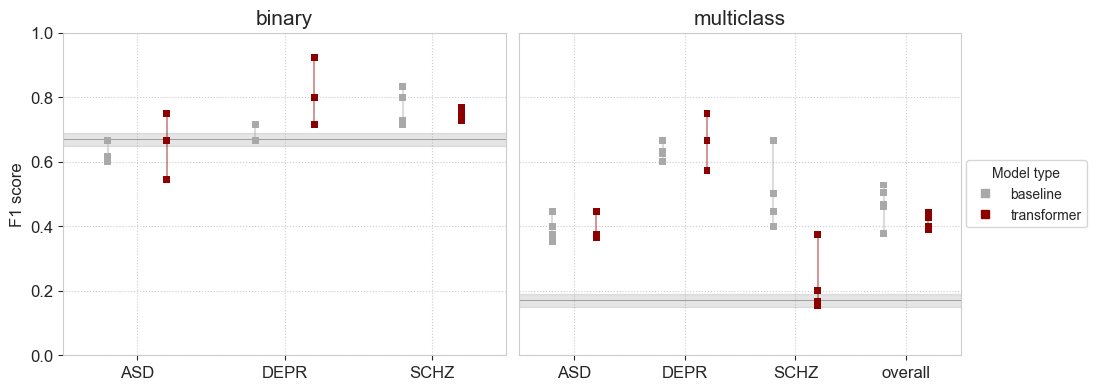

In [85]:
sns.set_style('whitegrid')
g = sns.catplot(data=combined, 
                x='class', y='value', marker='s',
                col='binary', sharex=False, 
                height=4.2, aspect=1.3, 
                dodge=.01,
                hue='model_type', 
                kind='strip', 
                jitter=False,
                hue_order=['baseline', 'transformer'],
                palette=['darkgrey', 'darkred'])
g.despine(right=False, top=False)
g.set_titles("{col_name}")
for ax in g.axes:
    for i, a in enumerate(ax):
        a.grid(linestyle='dotted')
        a.set_xlabel('')
        a.set_ylabel('F1 score', fontsize=12)
        a.set_ylim(0,1)
        a.set_title(label=a.get_title(), fontsize=15)
        a.tick_params(bottom=True, left=True, labelsize=12)
        if i==0:
            a.axhline(.67, color='grey', linewidth=.5)
            a.add_patch(Rectangle((-.6,.65), 5, .04,
                        angle=0,
                        edgecolor='grey',
                        facecolor='grey',
                        alpha=.2))
            for ix in range(3):
                a.axvline(x=ix+.2, 
                          ymin=lines[i][0][ix][0], 
                          ymax=lines[i][0][ix][1],
                          color='darkred', alpha=.4)
                a.axvline(x=ix-.2, 
                          ymin=lines[i][1][ix][0], 
                          ymax=lines[i][1][ix][1],
                          color='darkgrey', alpha=.4)
        else:
            a.set_ylabel('')
            a.tick_params(bottom=True, left=False, labelsize=12)
            a.axhline(.17, color='grey', linewidth=.5)
            a.add_patch(Rectangle((-.6,.15), 5, .04,
                        angle=0,
                        edgecolor='grey',
                        facecolor='grey',
                        alpha=.2))
            for ix in range(4):
                a.axvline(x=ix+0.2, 
                         ymin=lines[i][0][ix][0], 
                         ymax=lines[i][0][ix][1],
                          color='darkred', alpha=.4)
                a.axvline(x=ix-0.2, 
                          ymin=lines[i][1][ix][0], 
                          ymax=lines[i][1][ix][1],
                          color='darkgrey', alpha=.4)

# Make legend
g._legend.remove()
handles = g.legend.legendHandles
labels = [h.get_label() for h in handles]
handles = [Line2D([], [], color=c, linestyle='',
           marker='s')
           for c in ['darkgrey', 'darkred']]
labels, handles = zip(*sorted(zip(labels, handles)))
plt.legend(handles=handles, 
           labels=labels, 
           title="Model type", 
           bbox_to_anchor=(1.3, 0.5), 
           loc="center right")
plt.subplots_adjust(bottom=0.15, left=0.15)

# Save
plt.savefig('../figs/multiclass_vs_binary.png', dpi=300)
plt.show()


### Balanced accuracy per category

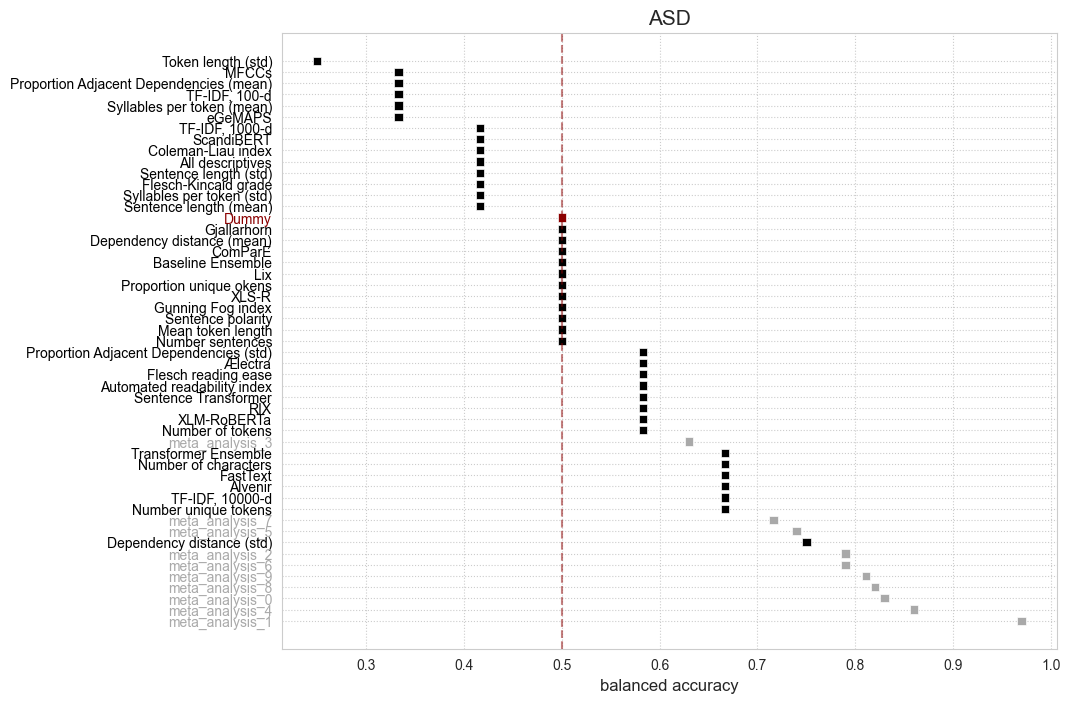

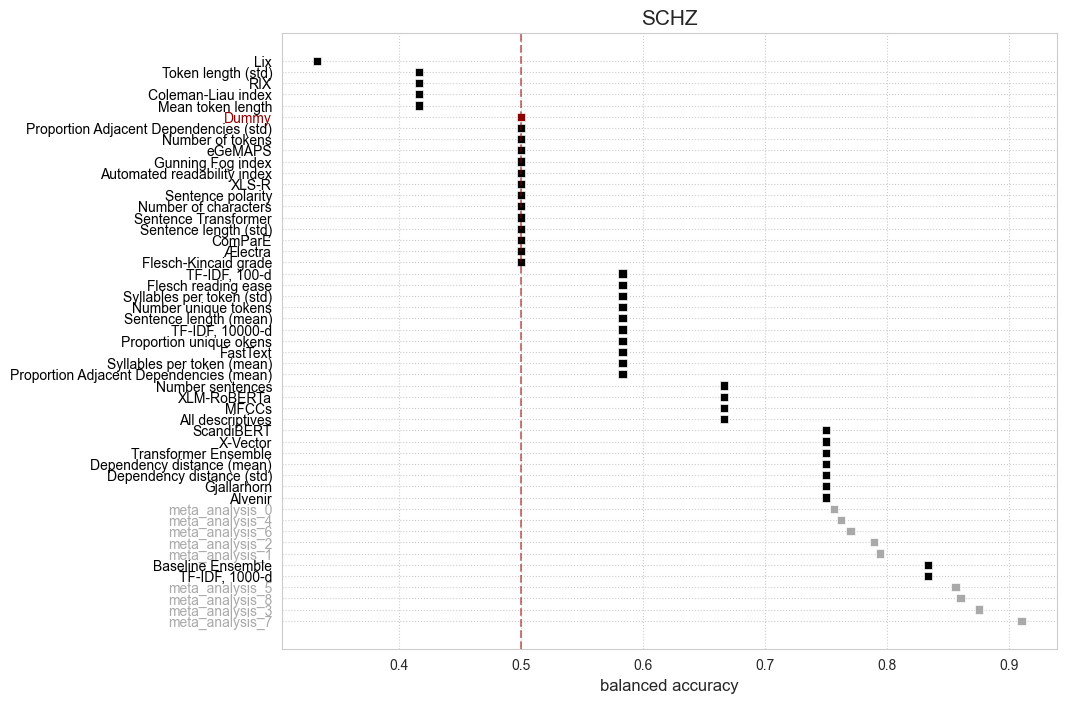

In [87]:
import numpy as np

conditions = [
    (binary_acc["model_id"].str.contains('analysis')),
    (binary_acc["model_id"].str.contains('Dummy')),
    ((~binary_acc["model_id"].str.contains('Dummy')) & 
     (~binary_acc["model_id"].str.contains('analysis'))),
]
choices = [2, 1, 0]
binary_acc["model_type"] = np.select(conditions, choices)

for c in ['ASD', 'SCHZ']:
    plt.subplots(figsize=(10,8))
    plt.axvline(.5, linestyle='dashed', color='darkred', alpha=.5)
    data = binary_acc[binary_acc['class']==c].sort_values(by='value')
    ax = sns.scatterplot(data=data,
                         x='value', y='model_id', 
                         marker='s', hue='model_type',
                         palette=['black', 'darkred', 'darkgrey'],
                         legend=False)
    ma_names = [n for n in data.model_id.tolist() if 'analysis' in n]
    other_names = [n for n in data.model_id.tolist() if 'analysis' not in n and 'Dummy' not in n]
    dummies = [n for n in data.model_id.tolist() if 'Dummy' in n]
    label_cols = []
    for model_n in data.model_id.unique():
        if model_n in ma_names:
            label_cols.append("darkgrey")
        elif model_n in other_names:
            label_cols.append("black")
        elif model_n in dummies:
            label_cols.append("darkred")
    [t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
    plt.title(f'{c}')
    ax.grid(linestyle='dotted')
    ax.set_title(label=ax.get_title(), fontsize=15)
    plt.xlabel('balanced accuracy', fontsize=12)
    plt.ylabel('')    
    plt.savefig(f'../figs/balanced_accuracy_{c}.png', dpi=300)
    plt.show()